Example 2.875
============

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find
errors or would like to suggest an improvement, feel free to create an
issue.

As usual we will start by importing some useful libraries.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In this notebook we will look at data on the mode of travel chosen by people travelling between Sydney and Melbourne (Australia). Relevant variables for us in this dataset are the mode of travel chosen: air, bus, car or train, the travel time, the generalised cost of the journey, the income of the household travelling and the number of people travelling together.

In [2]:
travel_dataset = sm.datasets.get_rdataset("TravelMode", "AER")
#print(travel_dataset.__doc__)
travel_df = travel_dataset.data

### Question

What units is `income` in?

### Answer

Although it doesn't state it explicitly in the meta-data, it appears this is a measure of the income in thousands of Australian dollars since this is on the order of the national average.

As a first pass we will look at modelling whether the selected mode was a train or car. The following snippet puts the data in a more tidy format for our analysis. Note that we have added a new variable, `is_car`, which is 1 if the travel was done by car and 0 if it was done by train.

In [3]:
#cleaning df
cb_df = travel_df[(travel_df["mode"] == "train") | (travel_df["mode"] == "car")] #check if travel mode is car or train
cb_df = cb_df[cb_df["choice"] == "yes"] #only choose if choice is above is car or train "yes" from above
cb_df = cb_df[["mode", "income", "size"]]
cb_df = cb_df.rename(columns={"mode": "vehicle", "size": "num_people"})

predictor_names = ["income", "num_people"]

cb_df["is_car"] = 0 #set all variable to 0
cb_df.loc[cb_df["vehicle"] == "car","is_car"] = 1 #if the vehicle is car change it to 1  
print(cb_df.head(10))

   vehicle  income  num_people  is_car
3      car      35           1       1
7      car      30           2       1
11     car      40           1       1
15     car      70           3       1
19     car      45           2       1
21   train      20           1       0
31     car      12           1       1
35     car      40           1       1
39     car      70           2       1
43     car      15           2       1


### Question

Generate visualisations to see how the distribution of income among car and train trips. What do you notice?

[hint](https://aezarebski.github.io/misc/matplotlib/gallery.html#fig-06)

### Answer

As the boxplots below show journeys by car are more likely to have individuals from households with a larger income and be a larger group.

In [4]:
print(cb_df.shape)
#cb_df.head(20)
unique_vehicles = cb_df.vehicle.unique() #cars or trains 
grouped_values = {p : [cb_df[cb_df.vehicle == v][p] for v in unique_vehicles] for p in predictor_names}

(122, 4)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


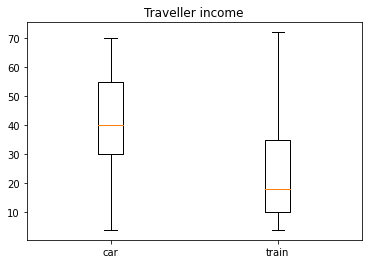

In [5]:
plt.figure()
plt.boxplot(x = grouped_values["income"], #boxplot with income as y axis
           labels = unique_vehicles) #boxplot split by car and train, group by unique values in the column 
plt.title("Traveller income")
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


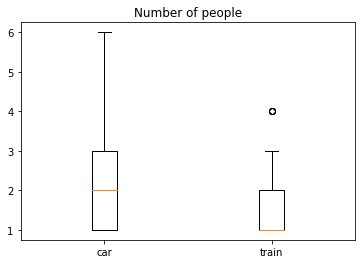

In [6]:
plt.figure()
plt.boxplot(x = grouped_values["num_people"], #number of peoople as the y axis instead
           labels = unique_vehicles) 
plt.title("Number of people")
plt.show()

### Question

Fit a logistic regression model to this data. Do the estimated coefficients make sense?

[hint](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.logit.html#statsmodels.formula.api.logit)

### Answer

We can use the `logit` function from `smf` to fit the logistic regression.

In [7]:
logistic_model = smf.logit(formula="is_car ~ income + num_people", data = cb_df).fit() #fit model with stats model formula, can write the equation

Optimization terminated successfully.
         Current function value: 0.560467
         Iterations 6


In [8]:
logistic_model.summary() #print out the prediction 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 is_car   No. Observations:                  122
Model:                          Logit   Df Residuals:                      119
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Nov 2021   Pseudo R-squ.:                  0.1908
Time:                        12:18:24   Log-Likelihood:                -68.377
converged:                       True   LL-Null:                       -84.498
Covariance Type:            nonrobust   LLR p-value:                 9.968e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2289      0.523     -4.263      0.000      -3.254      -1.204
income         0.0566      0.013      4.399      0.000       0.031       0.082
num_people     0.1885      0.201      0.936      0.349      -0.206       0.583
==============================================================================
"""

### Question

For a fixed income, what change does the model predict for each additional person on the journey? What happens to the odds, what happens to the log-odds?

### Answer

$$
\ln\left(\frac{p}{1-p}\right) = -2.2 + 0.06 \times \text{income} + 0.19 \times\text{num_people}
$$

For each additional person the *log-odds* of going by car increases by 0.19.

$$
\frac{p}{1-p} = e^{-2.2} (e^{0.06})^{\text{income}} + (e^{0.19})^{\text{num_people}}
$$

For each additional person the *odds* of going by car increase by a factor of $e^{0.19}$.

### Question

Write functions for logit and its inverse called `logit` and `inv_logit`.

[Hint](https://en.wikipedia.org/wiki/Logit#Definition)

### Answer

In [9]:
def logit(p):
    return np.log(p / (1 - p)) 

def inv_logit(a):
    return np.exp(a) / (np.exp(a) + 1)

The following snippet demonstrates one way to visualise the results of the model fit. If you have defined `logit` and `inv_logit` above this should make a sensible figure...

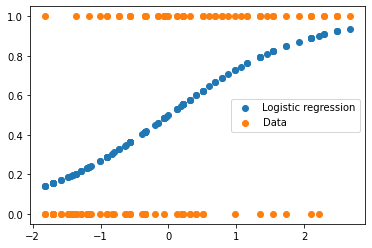

In [10]:
prob_is_car = logistic_model.predict() #sigmoid function of probability of whether a car is used
log_odds_is_car = logit(prob_is_car) 

plt.figure()
plt.scatter(log_odds_is_car, prob_is_car, label="Logistic regression") #plot the logistic model
plt.scatter(log_odds_is_car, cb_df["is_car"], label = "Data") #plot the real data 1 - car, 0 - train 
plt.legend()
plt.show()

### Question

For journeys with 2 people, plot the probability of going by car (as opposed to train) as a function of household income. Use this figure to find out the income at which it becomes more likely they will travel by car.

### Answer

We can evaluate the predicted probability at a range of income levels and then read off the plot that this changes at about 32.5 thousand.

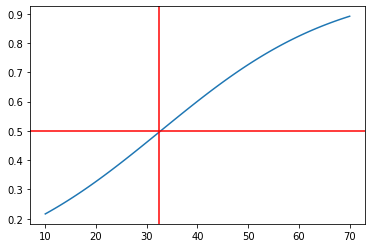

In [12]:
income_vals = np.linspace(10, 70, 100) #create income data

#find the intercept and beta for income and number of people, basically get the value from the summary model above  
theta_int = logistic_model.params.Intercept 
theta_income = logistic_model.params.income
theta_num = logistic_model.params.num_people

prob_car = inv_logit(theta_int + theta_income * income_vals + theta_num * 2) #find the probabilty of going by car with 2 people

plt.figure()
plt.plot(income_vals, prob_car) #income level on x axis, y is the probabiltiy of taking a car 
plt.axhline(0.5, color='r')
plt.axvline(32.5, color='r')
plt.show()

### Question

Plot the probability of going by car for 1, 2, and 3 people as a function of income. What do you notice about the change in the probability as a function of income?

### Answer

The change in probability is non-linear and depends upon the other variables. 

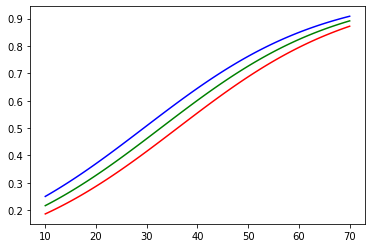

In [13]:
income_vals = np.linspace(10, 70, 100)

#same as above get the values 
theta_int = logistic_model.params.Intercept
theta_income = logistic_model.params.income
theta_num = logistic_model.params.num_people

prob_car_fn = lambda n : inv_logit(theta_int + theta_income * income_vals + theta_num * n) #instead of *2 here we times by n 

plt.figure()
plt.plot(income_vals, prob_car_fn(1), color='r') #probabilty of 1 person going by car
plt.plot(income_vals, prob_car_fn(2), color='g') #probabilty of 2 person going by car
plt.plot(income_vals, prob_car_fn(3), color='b') #probabilty of 3 person going by car
plt.show()

## Bonus Example: Multiple logistic regression

### Question

Set up a multiple logistic regression model to predict the mode of transport used based on all of the data.

### Answer

In [ ]:
#data cleaning
all_df = travel_df[travel_df["choice"] == "yes"] #filter only choice is yes 
all_df = all_df[["mode", "income", "size"]] #slicing df
all_df = all_df.rename(columns={"mode": "vehicle", "size": "num_people"}) #rename column 

all_df["vehicle_int"] = 0 #set all vehicle to 0 
all_df.loc[all_df["vehicle"] == "air","vehicle_int"] = 1 #if vehicle is air, set to 1 
all_df.loc[all_df["vehicle"] == "bus","vehicle_int"] = 2 #if vehicle is bus, set to 2
all_df.loc[all_df["vehicle"] == "car","vehicle_int"] = 3 #if vehicle is car, set to 3
all_df.loc[all_df["vehicle"] == "train","vehicle_int"] = 4 #if vehicle is train, set to 4
all_df.vehicle.value_counts() #count the amount in each transportation 

train    63
car      59
air      58
bus      30
Name: vehicle, dtype: int64

In [ ]:
multi_logistic = smf.mnlogit(formula = "vehicle_int ~ income + num_people", data = all_df).fit() #write down the equation where y is vehicle_int predicted by income and number of people
multi_logistic.summary() #print result from fitting model 

Optimization terminated successfully.
         Current function value: 1.206385
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:            vehicle_int   No. Observations:                  210
Model:                        MNLogit   Df Residuals:                      201
Method:                           MLE   Df Model:                            6
Date:                Wed, 24 Nov 2021   Pseudo R-squ.:                  0.1072
Time:                        16:42:56   Log-Likelihood:                -253.34
converged:                       True   LL-Null:                       -283.76
Covariance Type:            nonrobust   LLR p-value:                 3.044e-11
=================================================================================
vehicle_int=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0345      0.651      1.588      0.112      -0.242       2.311
income           -0.0339      0.013     -2.618      0.009      -0.059      -0.009
num_people       -0.3399      0.337     -1.009      0.313      -1.000       0.320
---------------------------------------------------------------------------------
vehicle_int=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.9435      0.550     -1.716      0.086      -2.021       0.134
income           -0.0035      0.010     -0.344      0.731      -0.024       0.017
num_people        0.6006      0.199      3.015      0.003       0.210       0.991
---------------------------------------------------------------------------------
vehicle_int=4       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5504      0.520      2.983      0.003       0.532       2.569
income           -0.0609      0.012     -5.139      0.000      -0.084      -0.038
num_people        0.2907      0.226      1.288      0.198      -0.152       0.733
=================================================================================
"""